In [115]:
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import feature_extraction as fx
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import numpy as np




filename = 'dataset_adapted_pca.csv' # Mix 50% normal and 50% anomaly

In [116]:
# model = anomaly.LocalOutlierFactor(n_neighbors=20)

model = anomaly.QuantileFilter(
    anomaly.LocalOutlierFactor(n_neighbors=20),
    q=0.95,
    protect_anomaly_detector=False                 # SIN ESTO FUNCIONA; AHORA LO ESTOY PROBANDO CON ESTE PARÁMETRO
)


In [117]:
# List of columns to keep
dataset = pd.read_csv(filename, index_col=False)


# Divide dataset into train and test
# Obtain 10000 samples for training that contains benign samples remove from the dataset
# Select first 10000 rows where 'Label' is 0
dataset_train = dataset.loc[dataset['Label'] == 0].iloc[:500]

# Drop these rows from the original dataset
dataset_test = dataset.drop(dataset_train.index)
# Drop benign samples from the test dataset
dataset_test = dataset_test.drop(dataset_test.loc[dataset_test['Label'] == 0].iloc[:4494].index)

print("Number of elements in the training dataset: ", len(dataset_train))
print("Number of elements in the test dataset: ", len(dataset_test))
print("\tBenign samples: ", len(dataset_test.loc[dataset['Label'] == 0]))
print("\tAnomaly samples: ", len(dataset_test.loc[dataset['Label'] == 1]))


# Shuffle dataset_test
dataset_test = dataset_test.sample(frac=1).reset_index(drop=True)

# Separate the label
dataset_train_no_labels = dataset_train.drop(columns=['Label'])
dataset_test_no_labels = dataset_test.drop(columns=['Label'])

Number of elements in the training dataset:  500
Number of elements in the test dataset:  5012
	Benign samples:  2506
	Anomaly samples:  2506


In [118]:
# Traning phase

# Create a list of scores
for i, row in dataset_train_no_labels.iterrows():
    model.learn_one(row.to_dict())
print("Traning phase completed")


Traning phase completed


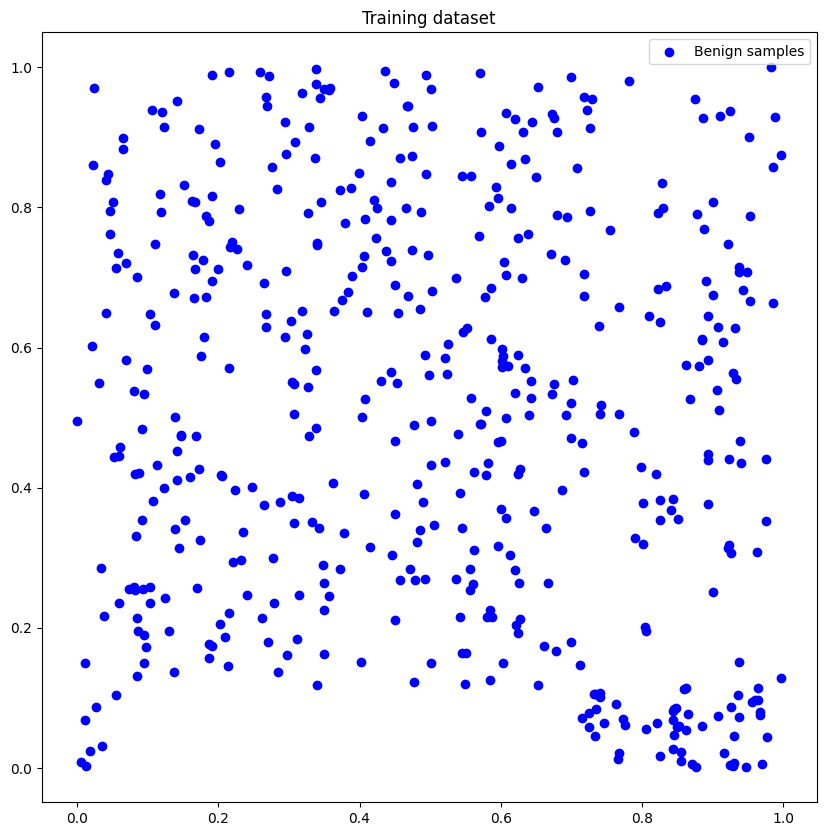

In [119]:
# Plot training dataset
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.figure(figsize=(10, 10))
plt.scatter(dataset_train_no_labels['PCA1'], dataset_train_no_labels['PCA2'], c='blue', label='Benign samples')
plt.title('Training dataset')

plt.legend(handler_map={plt.Line2D: HandlerPathCollection(update_func=update_legend_marker_size)})

plt.show()


In [120]:
# Testing phase

# Create a list of scores
anomalies = []

accuracies = []

fp = 0
fn = 0
tp = 0
tn = 0

for idx in dataset_test_no_labels.index:
    row = dataset_test_no_labels.loc[idx]
    print("Row: ", idx)
    print(row.to_dict())
    print(dataset_test.loc[idx].to_dict())
    score = model.score_one(row.to_dict())
    is_anomaly = model.classify(score)
    anomalies.append(is_anomaly)
    print("Is anomaly: ", is_anomaly)
    if not is_anomaly:
        model.learn_one(row.to_dict())  # Aprende solo de datos benignos si lo deseas
    label = dataset_test.loc[idx, "Label"]
    print("Score: " + str(score) + " Label: " + str(label))
    
    if is_anomaly and label == 1:
        tp += 1
    elif not is_anomaly and label == 0:
        tn += 1
    elif is_anomaly and label == 0:
        fp += 1
    else:
        fn += 1

    accuracies.append((tp + tn) / (tp + tn + fp + fn))

accuracy = (tp + tn) / (tp + tn + fp + fn)
print("Accuracy: ", accuracy)
if tp + fp == 0:
    precision = 0
else:
    precision = tp / (tp + fp)
print("Precision: ", precision)
recall = tp / (tp + fn)
print("Recall: ", recall)
false_positive_rate = fp / (fp + tn)
print("False Positive Rate: ", false_positive_rate)
if precision + recall == 0:
    f1 = 0
else:
    f1 = 2 * (precision * recall) / (precision + recall)
print("F1: ", f1)


Row:  0
{'PCA1': 0.7263298383317435, 'PCA2': 0.8841879562829521, 'PCA3': 0.8588588588588588, 'PCA4': 0.4984984984984985, 'PCA5': 1.0, 'PCA6': 1.0, 'PCA7': 0.0, 'PCA8': 0.0}
{'PCA1': 0.7263298383317435, 'PCA2': 0.8841879562829521, 'PCA3': 0.8588588588588588, 'PCA4': 0.4984984984984985, 'PCA5': 1.0, 'PCA6': 1.0, 'PCA7': 0.0, 'PCA8': 0.0, 'Label': 1.0}
Is anomaly:  True
Score: 4.072815893276816 Label: 1.0
Row:  1
{'PCA1': 0.3953953953953953, 'PCA2': 0.4354354354354354, 'PCA3': 0.90990990990991, 'PCA4': 0.6031031031031031, 'PCA5': 0.2692692692692692, 'PCA6': 0.5425425425425425, 'PCA7': 0.0, 'PCA8': 0.7322322322322322}
{'PCA1': 0.3953953953953953, 'PCA2': 0.4354354354354354, 'PCA3': 0.90990990990991, 'PCA4': 0.6031031031031031, 'PCA5': 0.2692692692692692, 'PCA6': 0.5425425425425425, 'PCA7': 0.0, 'PCA8': 0.7322322322322322, 'Label': 0.0}
Is anomaly:  False
Score: 1.203437492299802 Label: 0.0
Row:  2
{'PCA1': 0.0203076923076923, 'PCA2': 0.8942204872007827, 'PCA3': 0.8213213213213213, 'PCA4': 

In [121]:
# # Convert dataframe to numoy array
dataset_test = dataset_test.to_numpy()

colors = []

for anomaly in anomalies:
    if anomaly:
        colors.append('red')
    else:
        colors.append('blue')

# plt.scatter(dataset_test[:, 0], dataset_test[:, 1], color=colors, s=3.0, label="Data points")

# plt.axis("tight")
# plt.legend()

# plt.title("Local Outlier Factor (LOF)")
# plt.show()



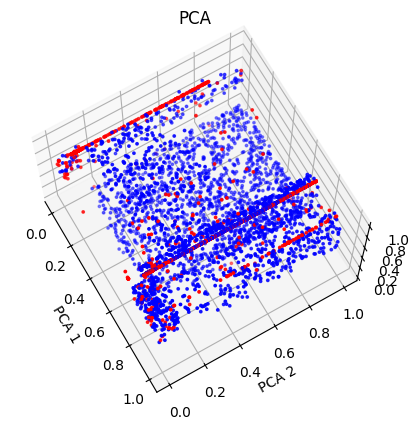

In [122]:
# Print in 3D

# Print in 3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset_test[:, 0], dataset_test[:, 1], dataset_test[:, 2], color=colors, s=3.0)


# Cambia el punto de vista
ax.view_init(elev=70, azim=-30)



plt.title('PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()


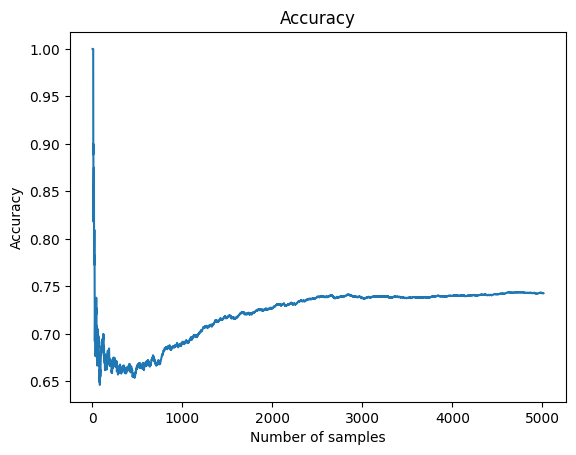

In [123]:
# Plot accuracies
sample_numbers = range(1, len(accuracies) + 1)

plt.plot(sample_numbers, accuracies)
plt.title('Accuracy')
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')

plt.show()